# Лабораторная 6. Статистические методы отбора признаков.

In [ ]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.datasets import load_wine, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Задание 1. Отбор признаков с использованием корреляционных матриц.

Для начала, используйте датасет о винах из sklearn.datasets. Найти корреляционную матрицу для датасета и, дополнительно, визуализируйте ее с помощью seaborn. 

In [2]:
ds_wine = load_wine()

df_wine = pd.DataFrame(ds_wine.data, columns = ds_wine.feature_names)

df_wine.head(7)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0


In [3]:
df_wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [4]:
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [5]:
df_wine.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [6]:
def anomalies_to_mean(df):
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1 

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        df[col] = df[col].apply(lambda x: df[col].mean() if x < lower_bound or x > upper_bound else x)

anomalies_to_mean(df_wine)

In [7]:
df_wine.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.280444,2.362526,19.384718,98.679586,2.295112,2.029270,0.361854,1.570235,4.912036,0.953222,2.611685,746.893258
std,0.811827,1.028666,0.247381,3.025508,12.246509,0.625851,0.998859,0.124453,0.537302,2.092561,0.221421,0.709990,314.907474
min,11.030000,0.740000,1.700000,11.200000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.212500,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.494944,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.960000,2.780000,673.500000
75%,13.677500,2.982500,2.540000,21.500000,106.000000,2.800000,2.875000,0.437500,1.942500,6.000000,1.120000,3.170000,985.000000
max,14.830000,5.190000,2.920000,27.000000,134.000000,3.880000,5.080000,0.660000,2.960000,10.520000,1.450000,4.000000,1680.000000


In [8]:
wine_corr = df_wine.corr()

wine_corr.head(7)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000000,0.095561,0.250555,-0.300168,0.371675,0.289101,0.236815,-0.155929,0.196917,0.554875,-0.027454,0.072343,0.643720
malic_acid,0.095561,1.000000,0.169181,0.291693,0.042627,-0.341916,-0.407380,0.266950,-0.252853,0.295844,-0.558425,-0.368537,-0.173128
ash,0.250555,0.169181,1.000000,0.333776,0.366929,0.093151,0.021109,0.157336,-0.003336,0.217374,-0.076001,-0.067397,0.243947
alcalinity_of_ash,-0.300168,0.291693,0.333776,1.000000,-0.153357,-0.413645,-0.483920,0.368414,-0.294260,-0.066721,-0.348742,-0.370036,-0.483080
magnesium,0.371675,0.042627,0.366929,-0.153357,1.000000,0.238941,0.226544,-0.223397,0.098850,0.328414,-0.009162,0.045419,0.429717
total_phenols,0.289101,-0.341916,0.093151,-0.413645,0.238941,1.000000,0.864564,-0.449935,0.616985,-0.052560,0.442627,0.699949,0.498115
flavanoids,0.236815,-0.407380,0.021109,-0.483920,0.226544,0.864564,1.000000,-0.537900,0.679466,-0.131481,0.558324,0.787194,0.494193


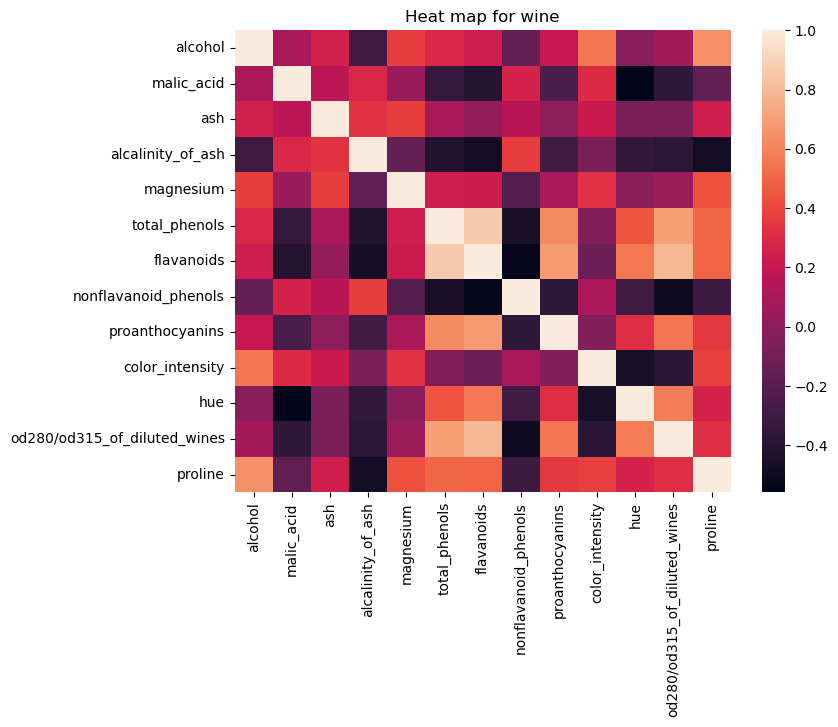

In [11]:
plt.figure(figsize=(8,6))   

sns.heatmap(wine_corr)

plt.title('Heat map for wine')
plt.show()

## Задание 2. Отбор признаков на основе важности признаков в случайном лесе.
Используйте тот же датасет и подгоните модель RandomForestRegressor к вашим данным, затем используйте атрибут feature_importances_ чтобы определить наиболее важные признаки.

In [10]:
RFG = RandomForestRegressor()

X = df_wine
y = ds_wine.target

RFG.fit(X, y)
feature_importances = RFG.feature_importances_

feature_importance_dict = dict(zip(X.columns, feature_importances))

sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f'Признак: {feature}, Важность: {importance}')

Признак: flavanoids, Важность: 0.5085981768463514
Признак: proline, Важность: 0.21486600783383852
Признак: color_intensity, Важность: 0.10841917655989705
Признак: od280/od315_of_diluted_wines, Важность: 0.10547460979687986
Признак: alcohol, Важность: 0.03607683055319369
Признак: hue, Важность: 0.01455892093434096
Признак: ash, Важность: 0.0031831749513373565
Признак: magnesium, Важность: 0.0025598068516861374
Признак: malic_acid, Важность: 0.002516691054211423
Признак: alcalinity_of_ash, Важность: 0.002161395772088579
Признак: proanthocyanins, Важность: 0.00105181504816013
Признак: total_phenols, Важность: 0.00029663572635271724
Признак: nonflavanoid_phenols, Важность: 0.00023675807166209864


## Задание 3. Использование выбора признаков на основе p-value.
Для этого задания можно использовать набор данных Boston Housing из sklearn.datasets. Был использован набор California Housing. 

Attribute Information:
+ MedInc        median income in block group
+ HouseAge      median house age in block group
+ AveRooms      average number of rooms per household
+ AveBedrms     average number of bedrooms per household
+ Population    block group population
+ AveOccup      average number of household members
+ Latitude      block group latitude
+ Longitude     block group longitude

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

In [11]:
ds_housing = fetch_california_housing()

df_housing = pd.DataFrame(ds_housing.data, columns=ds_housing.feature_names)
df_housing['target'] = ds_housing.target

df_housing.head(7)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992


In [12]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [13]:
df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [14]:
anomalies_to_mean(df_housing)

df_housing.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.664336,28.639486,5.243510,1.051495,1238.073265,2.849463,35.631861,-119.569704,1.916827
std,1.464216,12.585558,1.140138,0.064958,624.518272,0.617234,2.135952,2.003532,0.929971
min,0.499900,1.000000,2.032738,0.866013,3.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.447368,1.007732,787.000000,2.430380,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.235714,1.050399,1166.000000,2.818868,34.260000,-118.490000,1.797000
75%,4.546100,37.000000,5.960233,1.096675,1559.000000,3.199720,37.710000,-118.010000,2.414000
max,8.011300,52.000000,8.469738,1.239521,3132.000000,4.560748,41.950000,-114.310000,4.822000


In [ ]:
X = df_housing.drop(columns=['target']).astype(float)
y = df_housing['target'].astype(float)

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     3017.
Date:                Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:50:04   Log-Likelihood:                -19794.
No. Observations:               20640   AIC:                         3.961e+04
Df Residuals:                   20631   BIC:                         3.968e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -32.7928      0.578    -56.779      0.0

In [16]:
p_values = model.pvalues
ols_features = p_values[p_values < 0.05].index

print(f'Значимые признаки: {ols_features}')

X_filtered = X[ols_features]
model_filtered = sm.OLS(y, X_filtered).fit()
print(model_filtered.summary())

Значимые признаки: Index(['const', 'MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     3447.
Date:                Sun, 03 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:50:04   Log-Likelihood:                -19795.
No. Observations:               20640   AIC:                         3.961e+04
Df Residuals:                   20632   BIC:                         3.967e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|     

## Задание 4. Отбор признаков с помощью метода взаимной информации.

   Используйте любой датасет, с которым вам приятно работать. Установите библиотеку sklearn и примените функцию mutual_info_classif или mutual_info_regression для отбора признаков.

In [17]:
mig_scores = mutual_info_regression(X, y)

mig_features = X.columns[mig_scores > 0.05]

print(mig_features)

Index(['MedInc', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude'], dtype='object')


## Задание 5. Используйте метод Recursive Feature Elimination на том же датасете. 

Постройте модель, например, линейную регрессию или SVM, и используйте RFE для выбора лучшего подмножества признаков.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

LR = LinearRegression()
rfe = RFE(LR, n_features_to_select=5)

rfe.fit(X_train, y_train)

rfe_features = X.columns[rfe.support_]
print(rfe_features)

Index(['MedInc', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'], dtype='object')


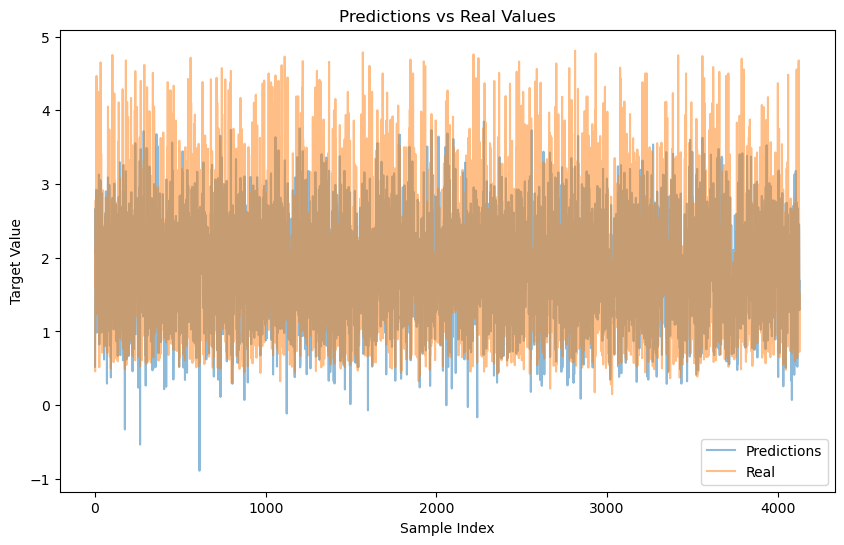

In [19]:
LR.fit(X_train[rfe_features], y_train)

predictions = LR.predict(X_test[rfe_features])

plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions', alpha=0.5)
plt.plot(y_test.values, label='Real', alpha=0.5)
plt.legend()
plt.title('Predictions vs Real Values')
plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.show()

In [20]:
mse = mean_squared_error(y_test, predictions)
print(f"MSE: {mse}")

MSE: 0.4102813170306131


## Задание 6. Сравние различные методы отбора признаков.
Примените каждый из методов отбора признаков к одному и тому же датасету, а затем сравните производительность моделей машинного обучения, обученных на этих различных подмножествах признаков.

MSE для OLS features: 0.40616647041931236
MSE для mutual_info_regression features: 0.4107995733519186
MSE для RFE features: 0.4102813170306131


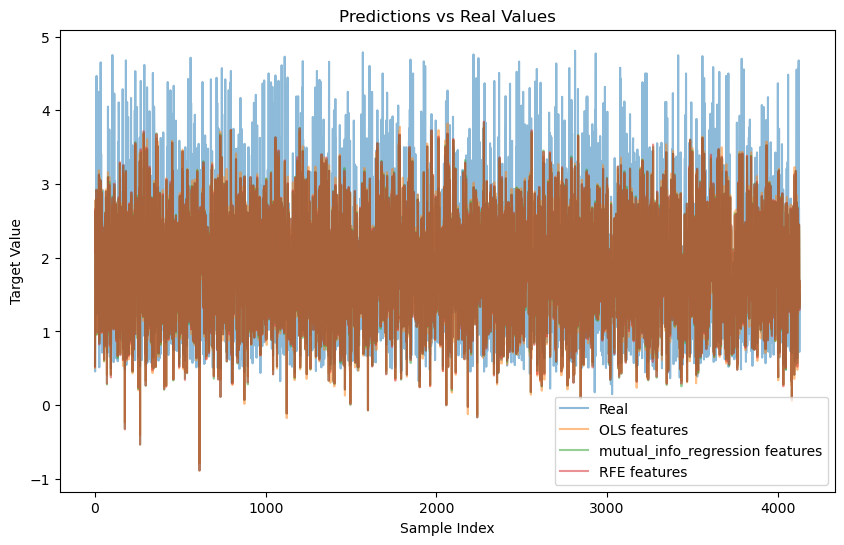

In [21]:
dict_features={'OLS features': ols_features,
              'mutual_info_regression features': mig_features,
              'RFE features': rfe_features}

plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Real', alpha=0.5)

for features in dict_features.keys():
    LR.fit(X_train[dict_features[features]], y_train)
    predictions = LR.predict(X_test[dict_features[features]])

    plt.plot(predictions, label=f'{features}', alpha=0.5)
    plt.title('Predictions vs Real Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Target Value')
    plt.legend()

    mse = mean_squared_error(y_test, predictions)
    print(f"MSE для {features}: {mse}")

plt.show()
    